In [1]:
import sys
sys.path.append("..")  # proje kök klasörüne erişim
import pandas as pd
import numpy as np
import json
import time
from utils.model_train_functions import ModelTrainFunctions
import catboost as cb
from catboost import CatBoostRegressor,Pool
import optuna
import warnings
import random
warnings.filterwarnings("ignore")

seed_value = 277
random.seed(seed_value)
np.random.seed(seed_value)

c:\Users\pc\Desktop\ULUDAG-ENERJI-DAGITILAN\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config_path = r"C:\Users\pc\Desktop\ULUDAG-ENERJI-DAGITILAN\data\raw\train_config.json"

with open(config_path, "r", encoding="utf-8") as f:
        config = json.load(f)

mtf = ModelTrainFunctions()

In [3]:
historical_data,forecast_data = mtf.get_data(data_path=config["train_data_path"])

In [4]:
train = historical_data.iloc[:-config["unseen_size"],:]
unseen = historical_data.iloc[-config["unseen_size"]:,:]
forecast = forecast_data.copy()
cat_cols = train.select_dtypes(include=["category","object"]).columns.tolist()
train.shape,unseen.shape,forecast.shape

((46032, 274), (744, 274), (48, 274))

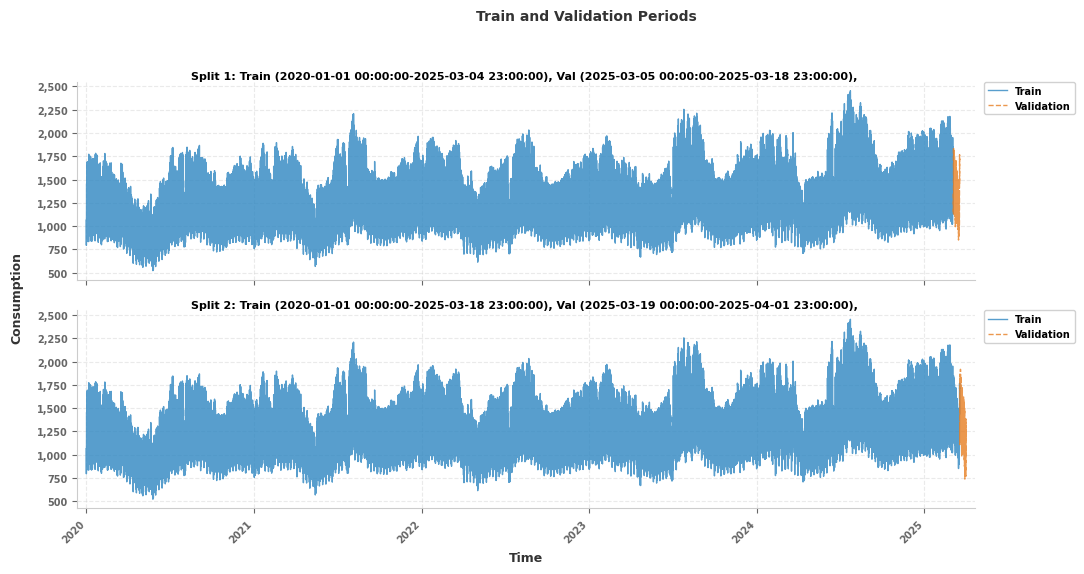

In [5]:
val_size = 336
n_splits = 2
splits_info = mtf.get_tscv_splits(pd.Series(pd.to_datetime(train.index)), n_splits=n_splits, test_size=val_size)
mtf.plot_splits(splits_info,train["consumption"])

In [6]:
mtf.print_splits_info(splits_info)

Split 1:
  Train: 2020-01-01 --> 2025-03-04
  Val:  2025-03-05 --> 2025-03-18
----------------------------------------
Split 2:
  Train: 2020-01-01 --> 2025-03-18
  Val:  2025-03-19 --> 2025-04-01
----------------------------------------


In [7]:
start_1 = time.time()
model_performance = {}
selected_cols = []

es = 50
verbose = 50

def objective(trial):
    model_performance[trial.number] = {}
    loss_function = trial.suggest_categorical('loss_function',['RMSE'])

    param = {   
        'iterations': trial.suggest_int('iterations', 100, 250),
        'loss_function' : loss_function,
        'eval_metric': trial.suggest_categorical('eval_metric', ['RMSE']),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        "allow_writing_files": False
    }

    start_time = time.time()
    global train
    data = train.copy()

    total_mape_train = 0
    total_mape_val = 0
    total_mape_unseen = 0

    split_count = len(splits_info)

    for split in splits_info:
        split_name = split['name']
        print(f"\n\nTraining on Trial: {trial.number} Split: {split_name}\n")
        train = data[split['train_period'][0]:split['train_period'][1]].drop(columns=selected_cols)
        val = data[split['val_period'][0]:split['val_period'][1]].drop(columns=selected_cols)
        X_train, y_train = train.drop(columns=["consumption"]), train["consumption"]
        print("Train data shape:", X_train.shape)
        print("Target length:", len(y_train))
        print("Any NaN in target:", y_train.isna().sum())
        print("Unique values in target:", y_train.unique())

        X_val, y_val = val.drop(columns=["consumption"]), val["consumption"]
        print(f"Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}")

        cat_cols = X_train.select_dtypes(include=["category", "object"]).columns.tolist()
        train_pool = Pool(X_train, label=y_train, cat_features=cat_cols)
        val_pool = Pool(X_val, label=y_val, cat_features=cat_cols)

        model = CatBoostRegressor(**param)
        model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=es, verbose=verbose)

        train_result = model.predict(X_train)
        val_result = model.predict(X_val)
        unseen_predict = model.predict(unseen.drop(columns="consumption"))

        train_mape_df, train_mape = mtf.calculate_mape(y_train, train_result)
        val_mape_df, val_mape = mtf.calculate_mape(y_val, val_result)
        unseen_mape_df, unseen_mape = mtf.calculate_mape(unseen["consumption"], unseen_predict)

        total_mape_train += train_mape
        total_mape_val += val_mape
        total_mape_unseen += unseen_mape

        print(f"Score Train - {split_name}: {train_mape},\nScore Val - {split_name}: {val_mape},\nScore Unseen - {split_name}: {unseen_mape}")
        print(f'Actual Mean: {np.mean(unseen["consumption"]):.3f},\nPredicted Mean: {np.mean(unseen_predict):.3f}')
        print('*'*50,"\n")

        # Model performansını kaydetme
        model_performance[trial.number][split_name] = {
            'hyperparameters': param,
            'model': model,
            'train_mape':train_mape,
            'val_mape':val_mape,
            'unseen_mape':unseen_mape,
            'evals_result': model.get_evals_result(),
            'importance': model.get_feature_importance(),
            'train_df':train_mape_df,
            'val_df': val_mape_df,
            'unseen_df': unseen_mape_df,
            "train": train,
            "val": val,
            "unseen": unseen
        }

    val_mape_set = {}
    for col in model_performance[trial.number].keys():
        val_mape = mtf.calculate_mape(model_performance[trial.number][col]["val_df"]["Gerçek"].values,model_performance[trial.number][col]["val_df"]["Tahmin"].values)[1]
        val_mape_set[col]  = val_mape
    val_mape_set = pd.DataFrame(data=val_mape_set.items(),columns=["Split","Val_MAPE"])
    val_mape_std = np.std(val_mape_set["Val_MAPE"])
    val_mape_mean = np.mean(val_mape_set["Val_MAPE"])

    base_average_mape = total_mape_val / split_count
    print(f"Trial completed in {(time.time() - start_time) / 60:.2f} minutes with average Validation MAPE: %{val_mape_mean:.3f} and STD: %{val_mape_std:.3f}")

    return val_mape_mean

study = optuna.create_study(direction="minimize",
                            study_name="CatBoost TSS Optimization",
                            sampler=optuna.samplers.TPESampler(
                                multivariate=True,
                                seed=seed_value))
study.optimize(objective, 
               n_trials=2,
               show_progress_bar=True,
               #n_jobs=-1
              )

end_1 = time.time()
print(f"Trials completed in {(end_1 - start_1) / 60:.2f} minutes")

[I 2025-06-22 02:28:56,156] A new study created in memory with name: CatBoost TSS Optimization
  0%|          | 0/2 [00:00<?, ?it/s]



Training on Trial: 0 Split: Split 1

Train data shape: (45360, 273)
Target length: 45360
Any NaN in target: 0
Unique values in target: [1063.48531906  993.9808637   910.94244226 ... 1678.9594335  1571.3341205
 1470.973085  ]
Training data shape: (45360, 273), Validation data shape: (336, 273)
0:	learn: 306.5491803	test: 234.7001635	best: 234.7001635 (0)	total: 233ms	remaining: 40s
50:	learn: 144.3380696	test: 91.3334535	best: 91.3334535 (50)	total: 2.67s	remaining: 6.38s
100:	learn: 88.7169631	test: 83.7373988	best: 79.6338565 (80)	total: 5.15s	remaining: 3.67s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 79.63385652
bestIteration = 80

Shrink model to first 81 iterations.
Score Train - Split 1: 6.11,
Score Val - Split 1: 4.57,
Score Unseen - Split 1: 7.37
Actual Mean: 1337.883,
Predicted Mean: 1330.456
************************************************** 



Training on Trial: 0 Split: Split 2

Train data shape: (45696, 273)
Target length: 45696
Any NaN in target:

Best trial: 0. Best value: 5.21:  50%|█████     | 1/2 [00:15<00:15, 15.64s/it]

172:	learn: 63.2402869	test: 96.2574378	best: 96.2574378 (172)	total: 8.44s	remaining: 0us

bestTest = 96.25743782
bestIteration = 172

Score Train - Split 2: 3.66,
Score Val - Split 2: 5.85,
Score Unseen - Split 2: 5.76
Actual Mean: 1337.883,
Predicted Mean: 1339.741
************************************************** 

Trial completed in 0.26 minutes with average Validation MAPE: %5.210 and STD: %0.640
[I 2025-06-22 02:29:11,801] Trial 0 finished with value: 5.21 and parameters: {'loss_function': 'RMSE', 'iterations': 173, 'eval_metric': 'RMSE', 'learning_rate': 0.021232079283489566}. Best is trial 0 with value: 5.21.


Training on Trial: 1 Split: Split 1

Train data shape: (45360, 273)
Target length: 45360
Any NaN in target: 0
Unique values in target: [1063.48531906  993.9808637   910.94244226 ... 1678.9594335  1571.3341205
 1470.973085  ]
Training data shape: (45360, 273), Validation data shape: (336, 273)
0:	learn: 300.5128683	test: 228.8720039	best: 228.8720039 (0)	total: 45.7ms	r

Best trial: 0. Best value: 5.21:  50%|█████     | 1/2 [00:20<00:20, 20.36s/it]

Stopped by overfitting detector  (50 iterations wait)

bestTest = 75.45155113
bestIteration = 34

Shrink model to first 35 iterations.
Score Train - Split 1: 6.47,
Score Val - Split 1: 4.34,
Score Unseen - Split 1: 7.45
Actual Mean: 1337.883,
Predicted Mean: 1331.346
************************************************** 



Training on Trial: 1 Split: Split 2

Train data shape: (45696, 273)
Target length: 45696
Any NaN in target: 0
Unique values in target: [1063.48531906  993.9808637   910.94244226 ... 1626.340915   1535.65365025
 1437.660567  ]
Training data shape: (45696, 273), Validation data shape: (0, 273)
[W 2025-06-22 02:29:16,514] Trial 1 failed with parameters: {'loss_function': 'RMSE', 'iterations': 108, 'eval_metric': 'RMSE', 'learning_rate': 0.04508737890324124} because of the following error: CatBoostError('Labels variable is empty.').
Traceback (most recent call last):
  File "c:\Users\pc\Desktop\ULUDAG-ENERJI-DAGITILAN\.venv\Lib\site-packages\optuna\study\_optimize.py", lin

CatBoostError: Labels variable is empty.